In [1]:
import pandas as pd

df = pd.read_parquet('../data/super_processed/7_4_no2_with_traffic_and_1meteo_and_1trafic_id.parquet')

In [2]:
df = df[df['id_no2'] == '28079056']

Total numeric columns found: 64
Columns: ['no2_value', 'intensidad', 'carga', 'ocupacion', 'd2m', 't2m', 'ssr', 'ssrd', 'u10', 'v10', 'sp', 'tp', 'wind_speed', 'wind_direction_deg', 'wind_dir_sin', 'wind_dir_cos', 'wind_speed_ma3', 'wind_speed_ma6', 'wind_speed_ma24', 't2m_ma6', 't2m_ma24', 'd2m_ma6', 'd2m_ma24', 'sp_ma6', 'sp_ma24', 'sp_ma72', 'u10_ma6', 'u10_ma24', 'v10_ma6', 'v10_ma24', 'wind_speed_ewm3', 't2m_ewm6', 'd2m_ewm6', 'sp_ewm12', 'u10_ewm6', 'v10_ewm6', 'ssr_sum24', 'ssrd_sum24', 'tp_sum6', 'tp_sum24', 'wind_dir_sin_ma6', 'wind_dir_sin_ma24', 'wind_dir_cos_ma6', 'wind_dir_cos_ma24', 'wind_dir_deg_ma6', 'wind_dir_deg_ma24', 'intensidad_lag1', 'intensidad_lag2', 'intensidad_lag3', 'intensidad_lag4', 'intensidad_lag6', 'intensidad_lag8', 'ocupacion_lag1', 'ocupacion_lag2', 'ocupacion_lag3', 'ocupacion_lag4', 'ocupacion_lag6', 'ocupacion_lag8', 'carga_lag1', 'carga_lag2', 'carga_lag3', 'carga_lag4', 'carga_lag6', 'carga_lag8']

=== Missing Values Check ===
Variables with miss

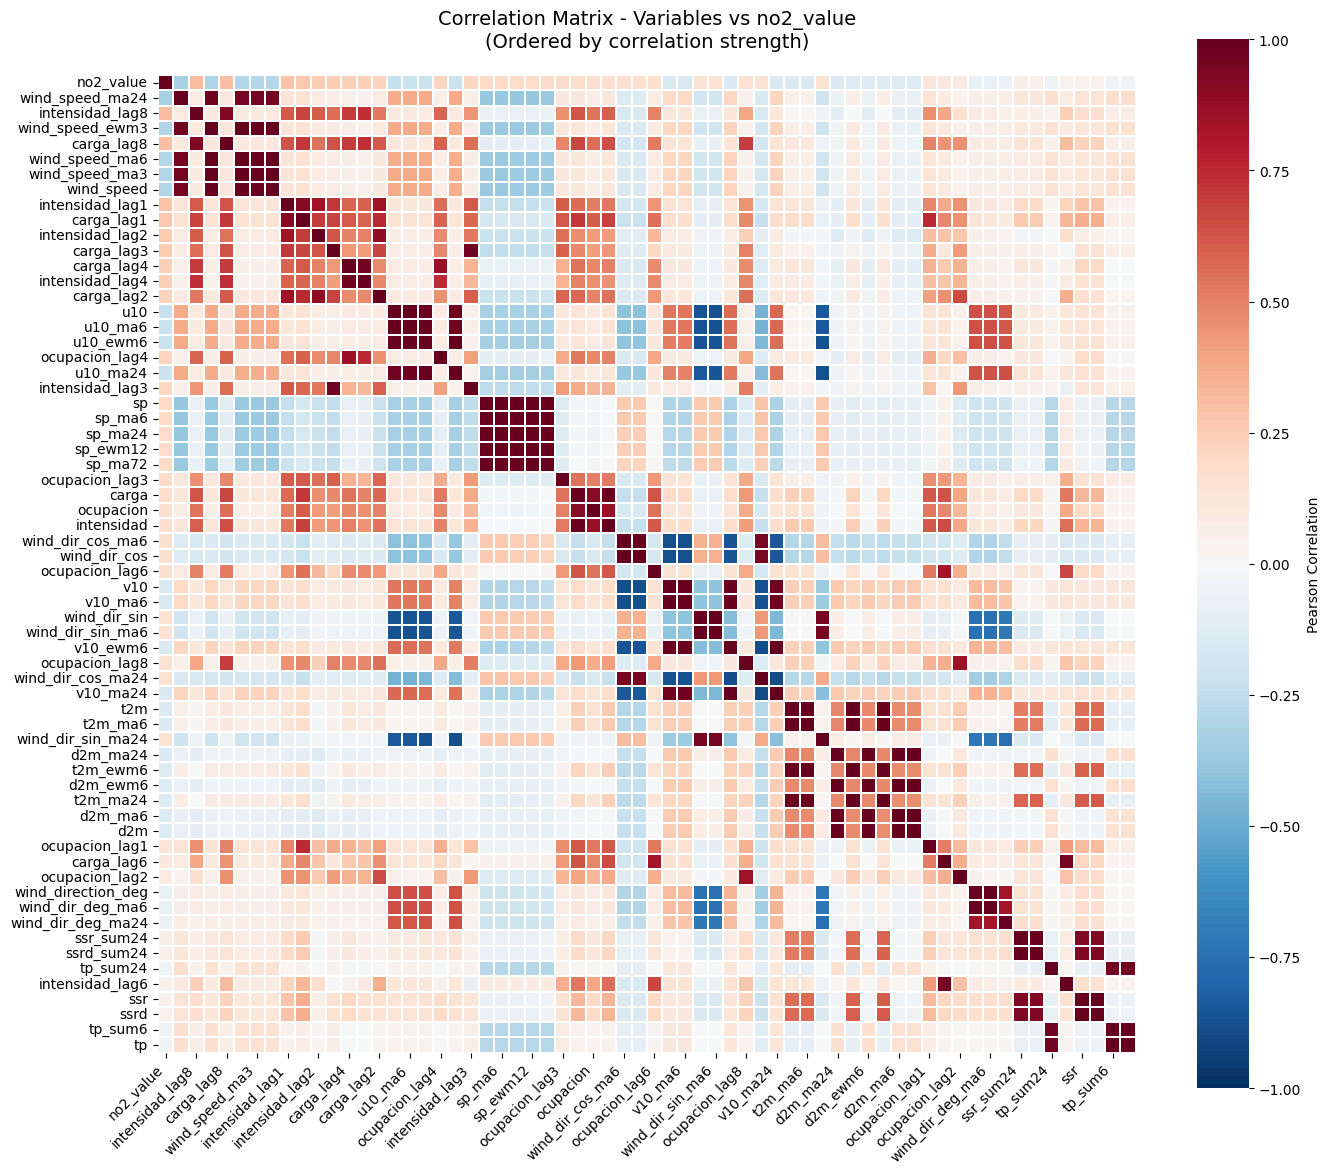


=== Top 30 Correlations with no2_value ===
wind_speed_ma24: 0.3293
intensidad_lag8: 0.3093
wind_speed_ewm3: 0.3034
carga_lag8: 0.2977
wind_speed_ma6: 0.2953
wind_speed_ma3: 0.2944
wind_speed: 0.2944
intensidad_lag1: 0.2838
carga_lag1: 0.2670
intensidad_lag2: 0.2561
carga_lag3: 0.2550
carga_lag4: 0.2411
intensidad_lag4: 0.2403
carga_lag2: 0.2307
u10: 0.2266
u10_ma6: 0.2264
u10_ewm6: 0.2226
ocupacion_lag4: 0.2225
u10_ma24: 0.2169
intensidad_lag3: 0.2128
sp: 0.2008
sp_ma6: 0.2007
sp_ma24: 0.1946
sp_ewm12: 0.1942
sp_ma72: 0.1913
ocupacion_lag3: 0.1911
carga: 0.1831
ocupacion: 0.1718
intensidad: 0.1647

=== Final Summary ===
Original correlation matrix had 64 variables
Cleaned correlation matrix has 64 variables


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------
# 1. Debug: Check your data before correlation
# ------------------------------------------------------------------
target = "no2_value"

# Get numeric columns (same as your code)
num_cols = (
    df.select_dtypes(include=["float32", "float64", "int32", "int64"])
      .drop(columns=["day_of_week", "day_of_year", "month", "year", "weekend",
                     "season", "hour", "day",'latitud_no2','longitud_no2','distance_m',
                     'latitud_trafico','longitud_trafico','latitud_meteo','longitud_meteo','vmed'], 
             errors="ignore")
      .columns
)

print(f"Total numeric columns found: {len(num_cols)}")
print(f"Columns: {list(num_cols)}")

# ------------------------------------------------------------------
# 2. Check for issues in the data
# ------------------------------------------------------------------
df_numeric = df[num_cols]

# Check for missing values
print("\n=== Missing Values Check ===")
missing_counts = df_numeric.isnull().sum()
print("Variables with missing values:")
print(missing_counts[missing_counts > 0])

# Check for constant values (these will have NaN correlation)
print("\n=== Constant Values Check ===")
constant_vars = []
for col in num_cols:
    if df_numeric[col].nunique() <= 1:
        constant_vars.append(col)
        print(f"{col}: {df_numeric[col].nunique()} unique values")

if constant_vars:
    print(f"Found {len(constant_vars)} constant variables (will have NaN correlation)")
else:
    print("No constant variables found")

# Check target variable specifically
print(f"\n=== Target Variable '{target}' Check ===")
if target in df_numeric.columns:
    print(f"Missing values in {target}: {df_numeric[target].isnull().sum()}")
    print(f"Unique values in {target}: {df_numeric[target].nunique()}")
    print(f"Data type: {df_numeric[target].dtype}")
else:
    print(f"ERROR: Target '{target}' not found in numeric columns!")

# ------------------------------------------------------------------
# 3. Calculate correlation and check for NaN values
# ------------------------------------------------------------------
df_corr = df_numeric.corr(method="pearson")

print(f"\n=== Correlation Matrix Check ===")
print(f"Correlation matrix shape: {df_corr.shape}")

# Check for NaN correlations
nan_correlations = df_corr.isnull().sum().sum()
print(f"Total NaN values in correlation matrix: {nan_correlations}")

if target in df_corr.columns:
    target_corr = df_corr[target]
    nan_with_target = target_corr.isnull().sum()
    print(f"Variables with NaN correlation to {target}: {nan_with_target}")
    
    if nan_with_target > 0:
        print("Variables with NaN correlation to target:")
        nan_vars = target_corr[target_corr.isnull()].index.tolist()
        print(nan_vars)

# ------------------------------------------------------------------
# 4. Clean correlation matrix and create improved plot
# ------------------------------------------------------------------
# Remove variables with NaN correlation to target
if target in df_corr.columns:
    valid_vars = df_corr[target].dropna().index
    df_corr_clean = df_corr.loc[valid_vars, valid_vars]
    
    print(f"\n=== Cleaned Data ===")
    print(f"Variables before cleaning: {len(df_corr.columns)}")
    print(f"Variables after cleaning: {len(df_corr_clean.columns)}")
    
    # Order by correlation with target
    order = (
        df_corr_clean[target]
        .abs()
        .sort_values(ascending=False)
        .index
    )
    
    df_corr_sorted = df_corr_clean.loc[order, order]
    
    # ------------------------------------------------------------------
    # 5. Create improved heatmap
    # ------------------------------------------------------------------
    plt.figure(figsize=(14, 12))
    
    # Create the heatmap
    sns.heatmap(df_corr_sorted,
                cmap="RdBu_r",  # Alternative colormap
                center=0,
                vmin=-1, vmax=1,
                linewidths=0.1,
                cbar_kws={"label": "Pearson Correlation"},
                square=True,  # Make cells square
                annot=False)   # Set to True if you want correlation values shown
    
    plt.title(f"Correlation Matrix - Variables vs {target}\n(Ordered by correlation strength)", 
              fontsize=14, pad=20)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Show top correlations with target
    print(f"\n=== Top 30 Correlations with {target} ===")
    top_corrs = df_corr_clean[target].abs().sort_values(ascending=False).head(30)  # 11 to exclude self
    for var, corr in top_corrs.items():
        if var != target:  # Skip self-correlation
            print(f"{var}: {corr:.4f}")

else:
    print(f"ERROR: Cannot proceed - target variable '{target}' not found!")

# ------------------------------------------------------------------
# 6. Alternative: Show all variables that exist in df_corr but not in plot
# ------------------------------------------------------------------
print(f"\n=== Final Summary ===")
print(f"Original correlation matrix had {len(df_corr.columns)} variables")
if 'df_corr_clean' in locals():
    print(f"Cleaned correlation matrix has {len(df_corr_clean.columns)} variables")
    removed_vars = set(df_corr.columns) - set(df_corr_clean.columns)
    if removed_vars:
        print(f"Removed variables: {list(removed_vars)}")

In [4]:
df_corr.to_csv('correlation_matrix_spearman.csv')

In [5]:
num_cols

Index(['no2_value', 'intensidad', 'carga', 'ocupacion', 'd2m', 't2m', 'ssr',
       'ssrd', 'u10', 'v10', 'sp', 'tp', 'wind_speed', 'wind_direction_deg',
       'wind_dir_sin', 'wind_dir_cos', 'wind_speed_ma3', 'wind_speed_ma6',
       'wind_speed_ma24', 't2m_ma6', 't2m_ma24', 'd2m_ma6', 'd2m_ma24',
       'sp_ma6', 'sp_ma24', 'sp_ma72', 'u10_ma6', 'u10_ma24', 'v10_ma6',
       'v10_ma24', 'wind_speed_ewm3', 't2m_ewm6', 'd2m_ewm6', 'sp_ewm12',
       'u10_ewm6', 'v10_ewm6', 'ssr_sum24', 'ssrd_sum24', 'tp_sum6',
       'tp_sum24', 'wind_dir_sin_ma6', 'wind_dir_sin_ma24', 'wind_dir_cos_ma6',
       'wind_dir_cos_ma24', 'wind_dir_deg_ma6', 'wind_dir_deg_ma24',
       'intensidad_lag1', 'intensidad_lag2', 'intensidad_lag3',
       'intensidad_lag4', 'intensidad_lag6', 'intensidad_lag8',
       'ocupacion_lag1', 'ocupacion_lag2', 'ocupacion_lag3', 'ocupacion_lag4',
       'ocupacion_lag6', 'ocupacion_lag8', 'carga_lag1', 'carga_lag2',
       'carga_lag3', 'carga_lag4', 'carga_lag6', 'carga_

In [6]:
df_corr_sorted

,no2_value,wind_speed_ma24,wind_speed_ewm3,intensidad_lag8,carga_lag3,wind_speed_ma6,carga_lag8,wind_speed_ma3,wind_speed,intensidad_lag3,...,d2m_ewm6,d2m_ma6,d2m,tp_sum24,tp,tp_sum6,ssr,ssrd,ssr_sum24,ssrd_sum24
no2_value,1.000000,-0.375984,-0.347281,0.347231,0.345931,-0.338960,0.338601,-0.338077,-0.338076,0.329487,...,-0.115062,-0.108773,-0.108633,-0.088092,-0.078666,-0.077807,0.061949,0.061073,0.060790,0.059497
wind_speed_ma24,-0.375984,1.000000,0.966489,0.073313,0.078899,0.950205,0.075902,0.947629,0.947629,0.067974,...,-0.064927,-0.068362,-0.068267,0.247985,0.255039,0.255623,0.149397,0.149290,0.155995,0.155971
wind_speed_ewm3,-0.347281,0.966489,1.000000,0.086796,0.089310,0.997921,0.089150,0.997127,0.997127,0.075790,...,-0.060520,-0.067898,-0.067975,0.237080,0.249214,0.249320,0.151420,0.151445,0.146015,0.146129
intensidad_lag8,0.347231,0.073313,0.086796,1.000000,0.767859,0.089278,0.948674,0.089513,0.089513,0.717556,...,-0.107051,-0.108597,-0.108585,0.180961,0.259640,0.259703,0.395730,0.394126,0.263016,0.260840
carga_lag3,0.345931,0.078899,0.089310,0.767859,1.000000,0.090692,0.784384,0.090808,0.090808,0.960534,...,-0.102339,-0.105054,-0.105122,0.153842,0.222133,0.223361,0.388458,0.388091,0.267280,0.266569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tp_sum6,-0.077807,0.255623,0.249320,0.259703,0.223361,0.246478,0.243387,0.246031,0.246031,0.187389,...,0.178806,0.176345,0.176301,0.930704,0.996294,1.000000,0.189154,0.188497,0.106675,0.105464
ssr,0.061949,0.149397,0.151420,0.395730,0.388458,0.150239,0.417667,0.150102,0.150102,0.314336,...,-0.027736,-0.032862,-0.032829,0.075370,0.195377,0.189154,1.000000,0.999826,0.861942,0.861406
ssrd,0.061073,0.149290,0.151445,0.394126,0.388091,0.150290,0.416403,0.150156,0.150156,0.314180,...,-0.025980,-0.031229,-0.031201,0.074669,0.194721,0.188497,0.999826,1.000000,0.861424,0.861255
ssr_sum24,0.060790,0.155995,0.146015,0.263016,0.267280,0.142193,0.286235,0.141530,0.141531,0.226683,...,-0.031606,-0.032395,-0.032141,0.127761,0.103284,0.106675,0.861942,0.861424,1.000000,0.999784


/opt/anaconda3/envs/master_thesis/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/master_thesis/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


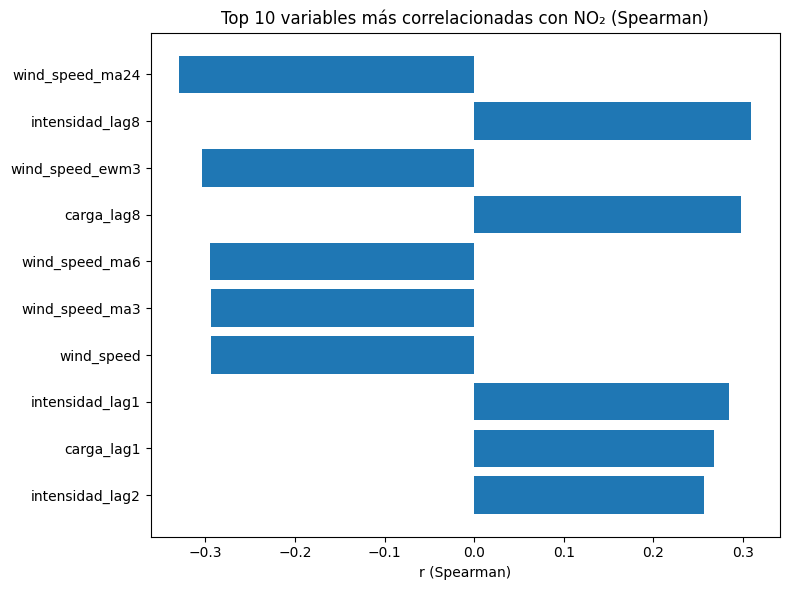

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Asumimos que el DataFrame `df` ya está en memoria
target = "no2_value"

# Seleccionamos columnas numéricas, excluyendo la diana
num_cols = df.select_dtypes(include=["float32", "float64", "int32", "int64"]).columns
num_cols = [col for col in num_cols if col != target]

# Correlaciones de Spearman
corr = df[num_cols].corrwith(df[target]).dropna()

# Top‑10 por magnitud absoluta
top10 = corr.reindex(corr.abs().sort_values(ascending=False).head(10).index)

# Gráfico de barras horizontales
plt.figure(figsize=(8, 6))
plt.barh(top10.index[::-1], top10.values[::-1])  # invertimos para que el mayor quede arriba
plt.xlabel("r (Spearman)")
plt.title("Top 10 variables más correlacionadas con NO₂ (Spearman)")
plt.tight_layout()
plt.show()

In [8]:
num_cols

['latitud_no2',
 'longitud_no2',
 'distance_m',
 'latitud_trafico',
 'longitud_trafico',
 'intensidad',
 'carga',
 'ocupacion',
 'vmed',
 'latitud_meteo',
 'longitud_meteo',
 'd2m',
 't2m',
 'ssr',
 'ssrd',
 'u10',
 'v10',
 'sp',
 'tp',
 'wind_speed',
 'wind_direction_deg',
 'wind_dir_sin',
 'wind_dir_cos',
 'day_of_week',
 'day_of_year',
 'month',
 'year',
 'weekend',
 'season',
 'hour',
 'day',
 'wind_speed_ma3',
 'wind_speed_ma6',
 'wind_speed_ma24',
 't2m_ma6',
 't2m_ma24',
 'd2m_ma6',
 'd2m_ma24',
 'sp_ma6',
 'sp_ma24',
 'sp_ma72',
 'u10_ma6',
 'u10_ma24',
 'v10_ma6',
 'v10_ma24',
 'wind_speed_ewm3',
 't2m_ewm6',
 'd2m_ewm6',
 'sp_ewm12',
 'u10_ewm6',
 'v10_ewm6',
 'ssr_sum24',
 'ssrd_sum24',
 'tp_sum6',
 'tp_sum24',
 'wind_dir_sin_ma6',
 'wind_dir_sin_ma24',
 'wind_dir_cos_ma6',
 'wind_dir_cos_ma24',
 'wind_dir_deg_ma6',
 'wind_dir_deg_ma24',
 'intensidad_lag1',
 'intensidad_lag2',
 'intensidad_lag3',
 'intensidad_lag4',
 'intensidad_lag6',
 'intensidad_lag8',
 'ocupacion_lag1',


/opt/anaconda3/envs/master_thesis/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


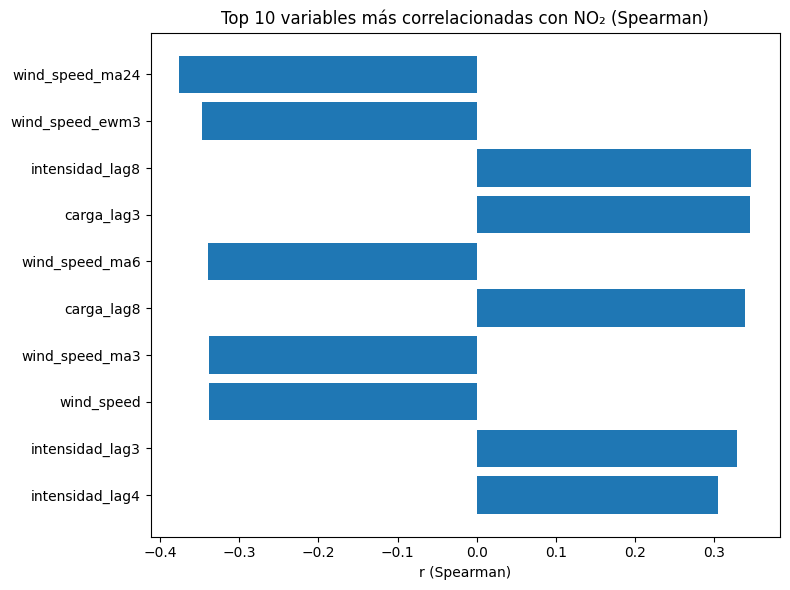

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Asumimos que el DataFrame `df` ya está en memoria
target = "no2_value"

# Seleccionamos columnas numéricas, excluyendo la diana
num_cols = df.select_dtypes(include=["float32", "float64", "int32", "int64"]).columns
num_cols = [col for col in num_cols if col != target]

# Correlaciones de Spearman
corr = df[num_cols].corrwith(df[target], method='spearman').dropna()

# Top‑10 por magnitud absoluta
top10 = corr.reindex(corr.abs().sort_values(ascending=False).head(10).index)

# Gráfico de barras horizontales
plt.figure(figsize=(8, 6))
plt.barh(top10.index[::-1], top10.values[::-1])  # invertimos para que el mayor quede arriba
plt.xlabel("r (Spearman)")
plt.title("Top 10 variables más correlacionadas con NO₂ (Spearman)")
plt.tight_layout()
plt.show()

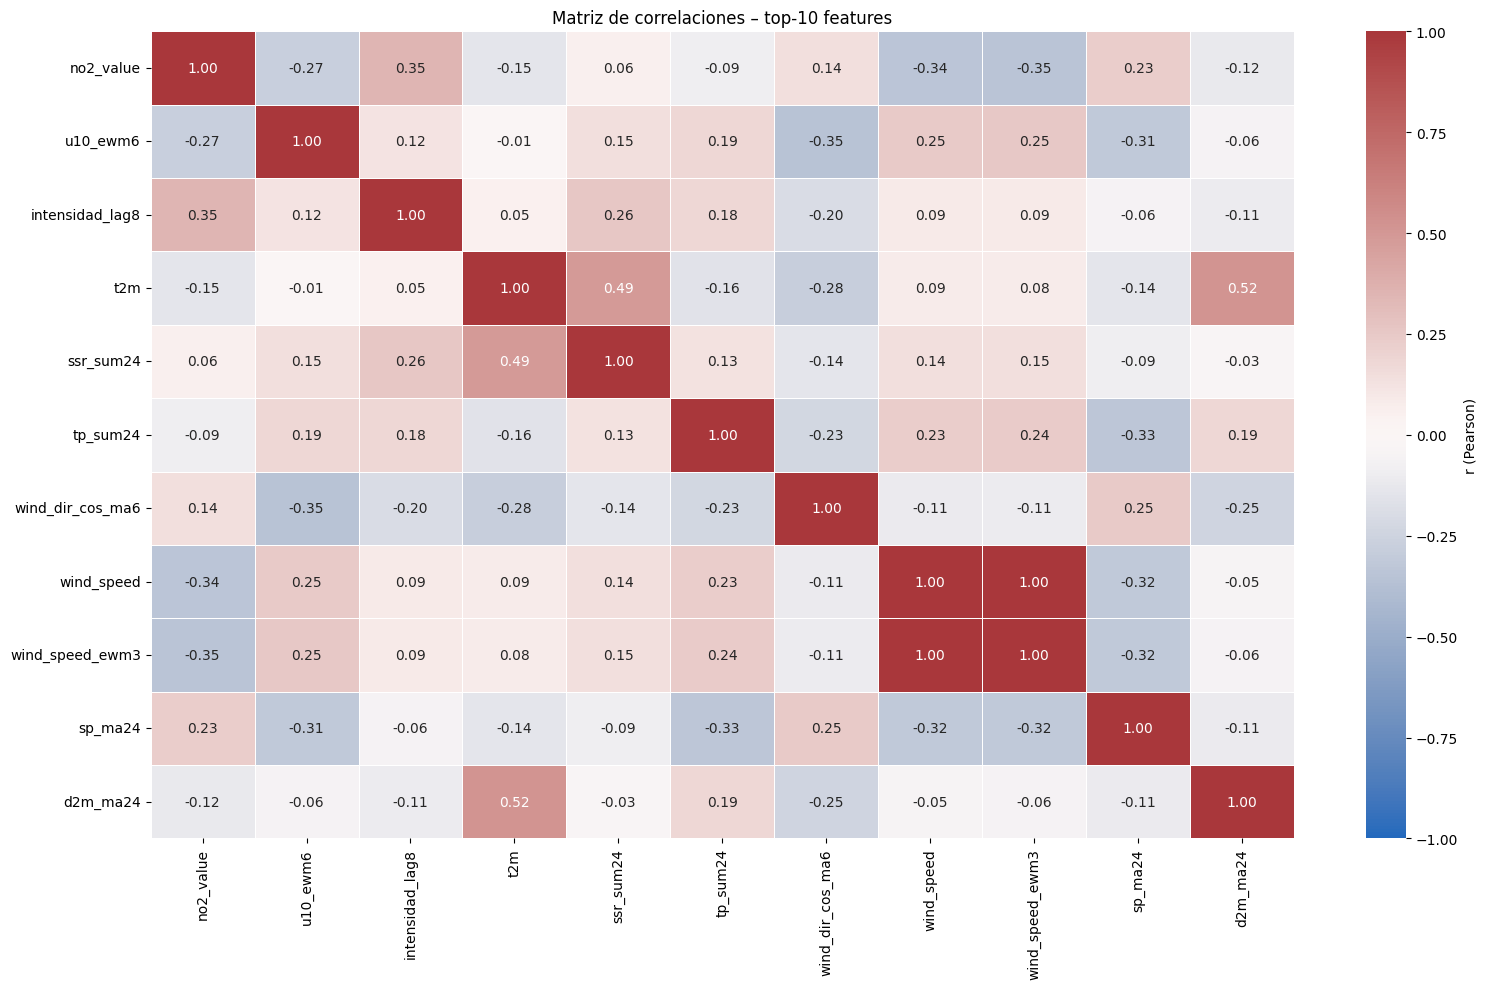

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# 1. Carga tu DataFrame con todas las columnas (df)
# ---------------------------------------------------------------
# df = pd.read_csv("tu_archivo.csv", parse_dates=["fecha"])  # ejemplo

# ---------------------------------------------------------------
# 2. Especifica las 10 variables de interés
# ---------------------------------------------------------------
top20 = [
    "no2_value",
    "u10_ewm6",
    "intensidad_lag8",
    "t2m",
    "ssr_sum24",
    "tp_sum24",
    "wind_dir_cos_ma6",
    "wind_speed",
    "wind_speed_ewm3",
    "sp_ma24",
    "d2m_ma24"
]

# ---------------------------------------------------------------
# 3. Calcula la matriz de correlaciones de Pearson
# ---------------------------------------------------------------
corr = df[top20].corr(method="spearman")

# ---------------------------------------------------------------
# 4. Dibuja un heat-map ordenado por |r| con NO₂ (opcional)
# ---------------------------------------------------------------
plt.figure(figsize=(16, 10))
sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    cmap="vlag", center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    cbar_kws={"label": "r (Pearson)"}
)
plt.title("Matriz de correlaciones – top-10 features")
plt.tight_layout()
plt.show()
